### Import Libraries

In [6]:
import numpy as np
import random
import os
from PIL import Image
import matplotlib.pyplot as plt
from inference import GWFSSModel
from datasets import load_from_disk
import pickle

### Import Data

In [7]:
# Load dataset and splits
print("Loading dataset and splits...")
dataset = load_from_disk('data/labelled')
with open('cache/splits.pkl', 'rb') as f:
    splits = pickle.load(f)

print(f"✓ Dataset loaded: {len(dataset)} images")
print(f"✓ Test set: {len(splits['test_indices'])} images")

Loading dataset and splits...
✓ Dataset loaded: 1096 images
✓ Test set: 165 images


### Random Sampling

✓ Validation images already exist. Loading...


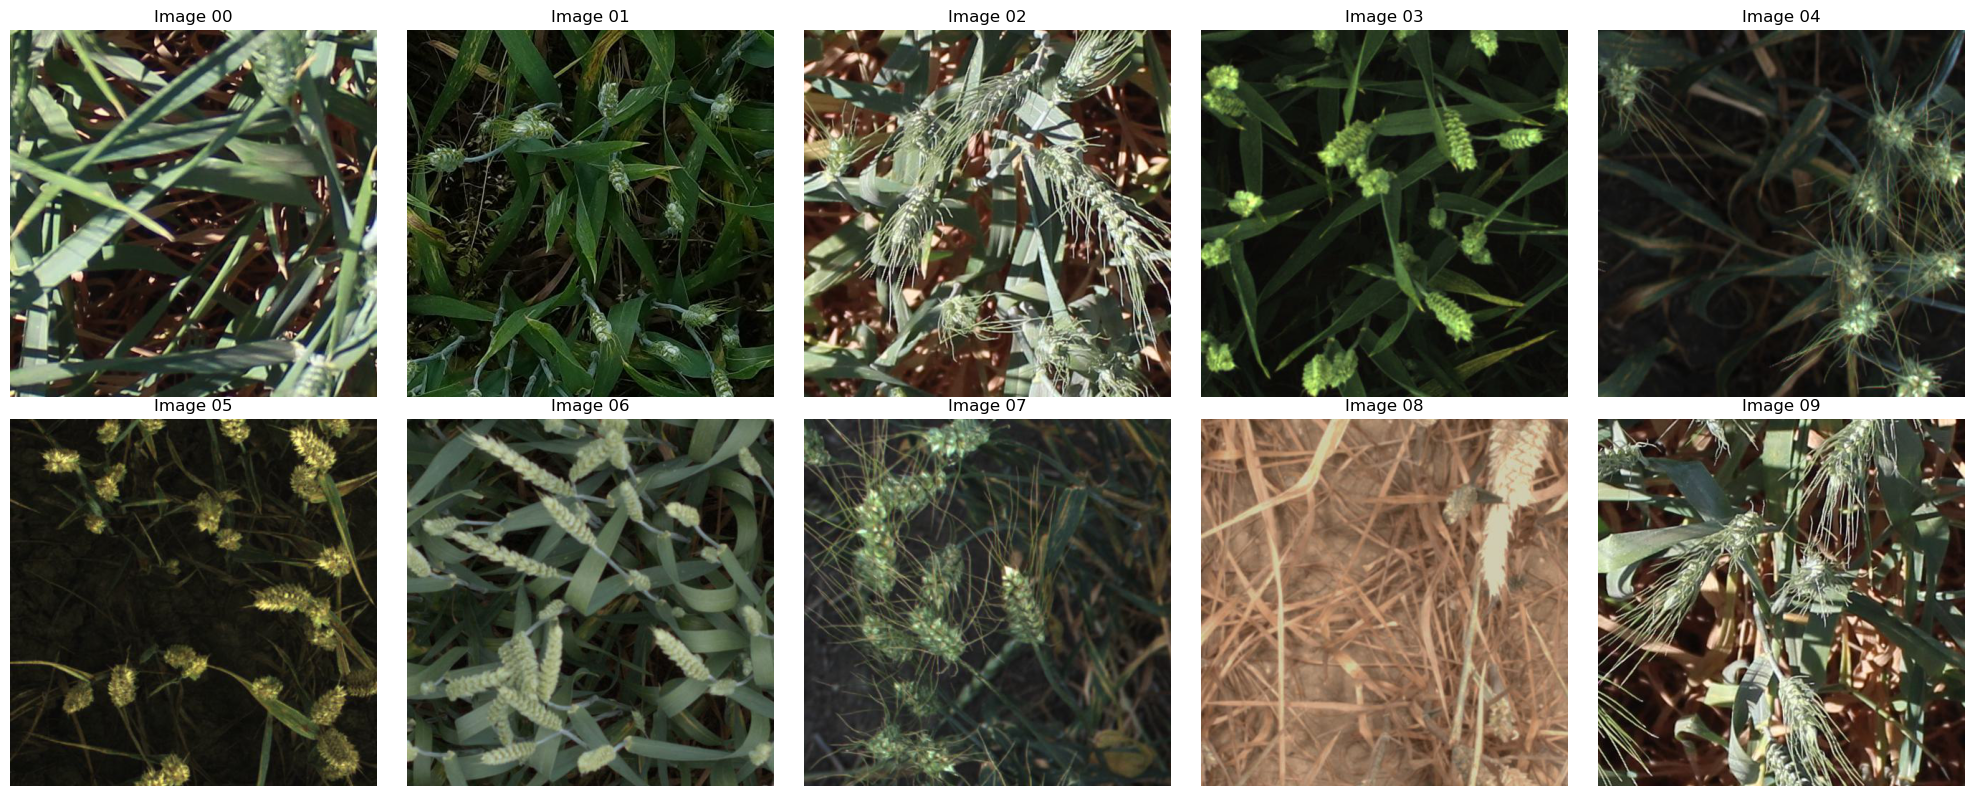

In [8]:
validation_dir = 'validation/images'

# Check if validation images already exist
if os.path.exists(validation_dir) and len(os.listdir(validation_dir)) == 10:
    print("✓ Validation images already exist. Loading...")
    
else:
    print("Generating validation images...")
    
    # Convert RGB mask to class indices
    def rgb_to_class(mask_rgb):
        mask_class = np.zeros(mask_rgb.shape[:2], dtype=np.uint8)
        colours = [
            (0, 0, 0),          # Background: 0
            (214, 255, 50),     # Leaf: 1
            (50, 132, 255),     # Stem: 2
            (50, 255, 132),     # Head: 3
        ]
        for class_id, colour in enumerate(colours):
            match = np.all(mask_rgb == colour, axis=-1)
            mask_class[match] = class_id
        return mask_class

    # Filter for images with heads
    test_indices = splits['test_indices']
    indices_with_heads = []

    print("Filtering test images for head content...")
    for idx in test_indices:
        mask_rgb = np.array(dataset[idx]['mask'])
        mask_class = rgb_to_class(mask_rgb)
        total_pixels = mask_class.size
        head_pixels = (mask_class == 3).sum()
        head_percentage = (head_pixels / total_pixels) * 100
        if head_percentage > 1.0:
            indices_with_heads.append((idx, head_percentage))

    print(f"Found {len(indices_with_heads)}/{len(test_indices)} test images containing heads")
    print("=" * 60)
    
    # Sample 10 random images
    random.seed(42)
    sample_data = random.sample(indices_with_heads, min(10, len(indices_with_heads)))
    
    # Create directory and save
    os.makedirs(validation_dir, exist_ok=True)
    
    for i, (idx, pct) in enumerate(sample_data):
        image = dataset[idx]['image']
        image.save(f'{validation_dir}/image_{i:02d}.jpg')
        print(f"image_{i:02d}.jpg: #{idx:03d}")
    
    print("=" * 60)
    print(f"✓ Saved {len(sample_data)} images to {validation_dir}/")

# Display all 10 images in a grid
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for i in range(10):
    img = Image.open(f'{validation_dir}/image_{i:02d}.jpg')
    axes[i].imshow(img)
    axes[i].set_title(f'Image {i:02d}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

### Inference

✓ Overlays already exist. Loading...


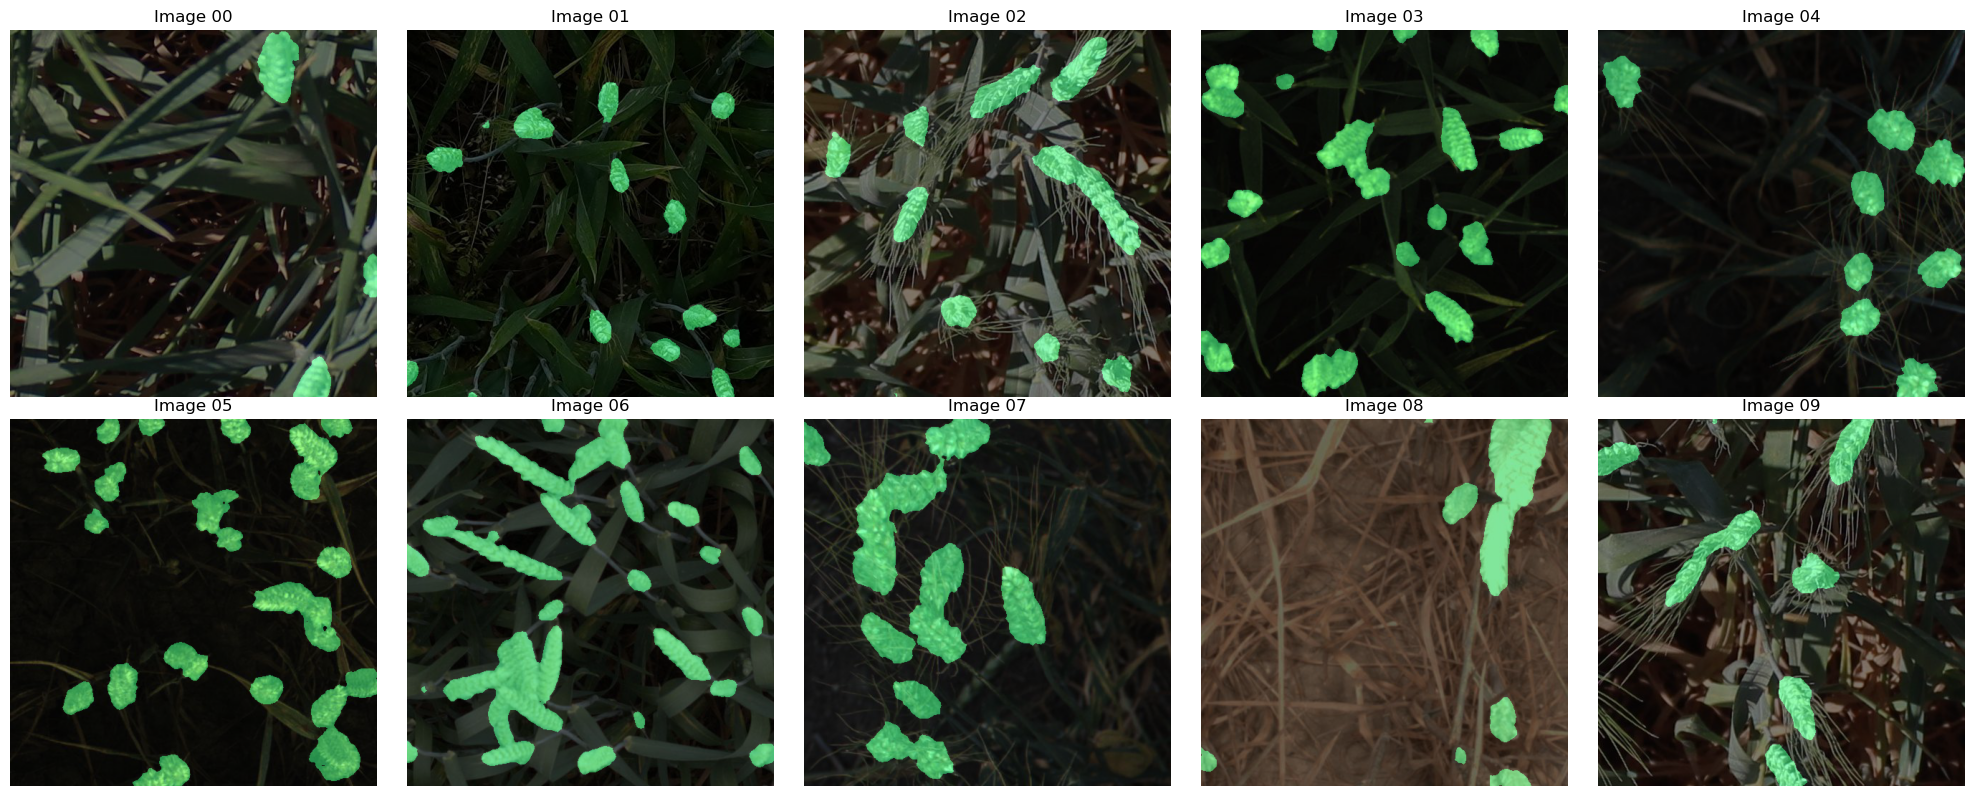

In [9]:
validation_dir = 'validation/images'
overlay_dir = 'validation/overlays'

# Check if overlays already exist
if os.path.exists(overlay_dir) and len([f for f in os.listdir(overlay_dir) if f.endswith('.png')]) == 10:
    print("✓ Overlays already exist. Loading...")
else:
    # Create overlay directory
    os.makedirs(overlay_dir, exist_ok=True)
    
    # Load model
    print("Loading model...")
    model = GWFSSModel('cache/02_dice_stem.pth')
    
    # Get all validation images
    image_files = sorted([f for f in os.listdir(validation_dir) if f.endswith('.jpg')])
    
    print(f"Running inference on {len(image_files)} validation images...")
    print("=" * 60)
    
    for img_file in image_files:
        image_path = os.path.join(validation_dir, img_file)
        
        # Run inference
        image = Image.open(image_path)
        predictions = model.predict(image)
        pred_count = model.count_heads(predictions)
        
        # Create visualisation (heads only)
        overlay = model.overlay_mask(image, predictions, alpha=0.5, heads_only=True)
        
        # Save overlay
        overlay_name = img_file.replace('.jpg', '_overlay.png')
        overlay_path = os.path.join(overlay_dir, overlay_name)
        overlay.save(overlay_path)
        
        print(f"{img_file}: {pred_count:2d} heads detected")
    
    print("=" * 60)
    print(f"✓ Saved overlays to {overlay_dir}/")

# Display inference overlays
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for i in range(10):
    overlay = Image.open(f'{overlay_dir}/image_{i:02d}_overlay.png')
    axes[i].imshow(overlay)
    axes[i].set_title(f'Image {i:02d}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

### Distance Parameter Calibration

In [13]:
# Test different min_distance values
min_distances = [10, 15, 20]

# Load model if not already loaded
if 'model' not in locals():
    print("Loading model for parameter tuning...")
    model = GWFSSModel('cache/02_dice_stem.pth')

print("\nTesting head counts with different min_distance values...")

# Store results for each parameter
results = {md: [] for md in min_distances}

for i in range(10):
    image_path = f'validation/images/image_{i:02d}.jpg'
    image = Image.open(image_path)
    predictions = model.predict(image)
    
    for min_dist in min_distances:
        count = model.count_heads(predictions, min_distance=min_dist)
        results[min_dist].append(count)

# Print as a table
print("=" * 60)
print(f"{'Image':<15}", end="")
for min_dist in min_distances:
    print(f"md={min_dist:<5}", end="  ")
print()
print("-" * 60)

for i in range(10):
    print(f"image_{i:02d}.jpg  ", end="")
    for min_dist in min_distances:
        print(f"{results[min_dist][i]:>6}  ", end="")
    print()

print("-" * 60)

# Summary statistics
print(f"{'Total':<15}", end="")
for min_dist in min_distances:
    total = sum(results[min_dist])
    print(f"{total:>6}  ", end="")
print()

print(f"{'Mean':<15}", end="")
for min_dist in min_distances:
    mean = sum(results[min_dist]) / 10
    print(f"{mean:>6.1f}  ", end="")
print()

print("=" * 60)


Testing head counts with different min_distance values...
Image          md=10     md=15     md=20     
------------------------------------------------------------
image_00.jpg       6       4       2  
image_01.jpg      13      13      12  
image_02.jpg      17      13      11  
image_03.jpg      21      19      17  
image_04.jpg       8       8       8  
image_05.jpg      30      24      22  
image_06.jpg      41      31      27  
image_07.jpg      15      14      13  
image_08.jpg       9       9       8  
image_09.jpg      13       9       7  
------------------------------------------------------------
Total             173     144     127  
Mean             17.3    14.4    12.7  


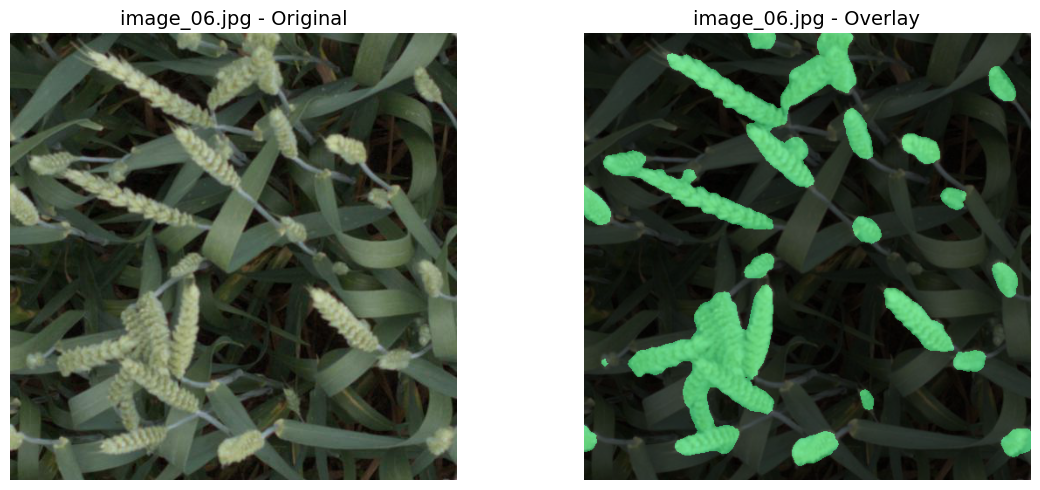

  min_distance = 10  →  41 heads detected
  min_distance = 15  →  31 heads detected
  min_distance = 20  →  27 heads detected


In [14]:
# Check image_06.jpg (highest parameter sensitivity)
image = Image.open(f'validation/images/image_06.jpg')
predictions = model.predict(image)
overlay = model.overlay_mask(image, predictions, alpha=0.5, heads_only=True)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Show original and overlay side by side
axes[0].imshow(image)
axes[0].set_title('image_06.jpg - Original', fontsize=14)
axes[0].axis('off')

axes[1].imshow(overlay)
axes[1].set_title('image_06.jpg - Overlay', fontsize=14)
axes[1].axis('off')

plt.tight_layout()
plt.show()

# Print counts for different parameters
for min_dist in min_distances:
    count = results[min_dist][6]
    print(f"  min_distance = {min_dist:2d}  →  {count:2d} heads detected")

The baseline parameter `min_distance=15` performs optimally on the most challenging validation image. This value will be used for deployment.